In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bz2
import itertools
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np
import lxml.etree

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Read and Vectorise Documents

First download a dump of Simple Wikipedia. By default we suppose it's placed under `../data/`.

Iterator on Simple Wiki's articles:

In [4]:
def articles_iter(dump='../data/simplewiki-latest-pages-articles.xml.bz2',
                  keyphrase=None):
    ''' Extract pages with keyphrase '''
    with bz2.open(dump) as pages:
        tree = lxml.etree.ElementTree(file=pages)
        for node in tree.iter(tag='{*}text'):
            if node.text is None:
                continue
            if keyphrase is None:
                yield node.text
            elif keyphrase in node.text:
                yield node.text

* TF-IDF Vectorizer

First fit the Vocabulary on the entire dataset, then transform only the documents containing phrase "United States" to obtain the doc-term matrix for the subset.

In [5]:
n_features = 20000

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=1,
                                   max_features=n_features,
                                   lowercase=False,
                                   stop_words='english')
tfidf_vectorizer.fit(articles_iter(keyphrase=None))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [7]:
tfidf = tfidf_vectorizer.transform(articles_iter(keyphrase='United States'))
tfidf.shape

(30285, 20000)

* TF Vectorizer

First fit the vectorizer on the entire dataset reusing the Vocabulary, then transform only the documents containing phrase "United States" to obtain the doc-term matrix for the subset.

In [9]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                lowercase=False,
                                stop_words='english',
                                vocabulary=tfidf_vectorizer.vocabulary_)
tf_vectorizer.fit(articles_iter(keyphrase=None))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'April': 2046, '4th': 1062, 'month': 16101, 'year': 19936, 'comes': 12565, 'March': 6920, 'May': 7024, 'It': 5972, 'months': 16105, '30': 801, 'day': 13048, 'begins': 11785, 'week': 19744, 'July': 6164, 'January': 6035, 'leap': 15505, 'years': 19942, 'ends': 13722, 'December': 3914, 'flo..., 'Args': 2092, 'bsq': 12032, 'XSAMPA': 10972, 'VGem': 10482, 'dodseal': 13440, 'contentcat': 12758})

In [10]:
tf = tf_vectorizer.transform(articles_iter(keyphrase='United States'))
tf.shape

(30285, 20000)

Distribution of NNZ of all documents

In [13]:
doc_lengths = (tf_vectorizer
               .transform(articles_iter(keyphrase=None))
               .sum(axis=1))
np.percentile(doc_lengths, [5, 25, 50, 75, 95])

array([  1.,   5.,  45., 163., 569.])

Text(0.5,1,'Histogram of NNZ of All Documents')

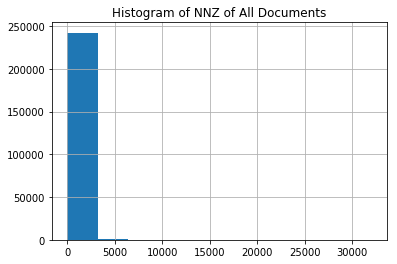

In [14]:
plt.hist(doc_lengths)
plt.grid()
plt.title('Histogram of NNZ of All Documents')

# Topic Modelling

In [10]:
def print_top_words_factors(factors, feature_names, n_top_words):
    ''' Print top words of each topic '''
    for topic_idx, topic in enumerate(factors):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_words(model, feature_names, n_top_words):
    ''' Print top words of each topic '''
    print_top_words_factors(model.components_, feature_names, n_top_words)

## NMF

In [13]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(tfidf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: American Category actor New York ndash He television actors actress politician singer born footballer German writer English The British 2014
Topic #1: County Alabama Area code Census Information Location List census counties City Zone Texas GNIS county area_land_sq_mi area_water_sq_mi area_total_sq_mi State elevation_ft
Topic #2: movies movie Category drama comedy Movies American br The It set language released directed crime italictitle English thriller romantic United
Topic #3: Illinois Cities US city geo Chicago stub States United Category Township map state Cook County Park Indiana City Democratic Mayor
Topic #4: Kentucky Cities city geo US States stub United County Category seats Kenton Ohio Harlan Hills Hardin Indiana Louisville Oklahoma county
Topic #5: States United Category Commonscat REDIRECT Party state Republican Arkansas President US establishments Democratic Senate Establishments New California Secretary America Washington
Topic #6: Iowa Cities city geo States U

## Latent Dirichlet Allocation

Variational Inference for LDA

In [14]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=1,
                                topic_word_prior=1,
                                max_iter=20,
                                learning_method='online')
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: ref http www com title url cite accessdate web publisher date html news https 2011 2016 The work 2012 org
Topic #1: County States United New city state Category nbsp City Area Jersey US River Florida Alabama State stub Census North Population
Topic #2: Category States United He American Party nowrap Army New br University January York US jpg Republican Democratic President John DEFAULTSORT
Topic #3: align center bgcolor style small br flagicon Grand left background Prix text rowspan Ret right width efcfff flag cfcfff colspan
Topic #4: The ref In people It wikt This They called United year used time He book thumb States like jpg pages
Topic #5: The Category br movie American music album movies series It film television com song Award Records United released TV Best
Topic #6: sort WWE World team Category Championship League Canada Wrestling Cup The football match year hockey br wrestling Team dash Olympics
Topic #7: font User talk color UTC span style sup article The Wikipedia 

## Spectral LDA

In [15]:
import sys
sys.path.insert(0, '../SpectralLDA')

from spectral_lda import spectral_lda

Using numpy backend.
Using numpy backend.


In [16]:
alpha, beta = spectral_lda(tf, alpha0=10, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 30285	# valid: 30285


Topic #0: County Category Kentucky geo US stub Cities United city States Florida Idaho towns Oklahoma Illinois seats county state Texas Arkansas
Topic #1: Category States United Commonscat American REDIRECT state New California Settlements movies York movie establishments deaths television century Geography nationality Buildings
Topic #2: States American movies movie New television York California Settlements He state series deaths It Movies actors seats drama DEFAULTSORT br
Topic #3: Iowa States United Cities Category geo stub city US Illinois Kentucky towns Idaho Florida Arkansas Indiana Oklahoma seats Commonscat state
Topic #4: stub ref http www The br com title Commonscat url cite accessdate web publisher American date align He New html
Topic #5: city ref The http www com br title url cite date accessdate web In It He publisher American music small
Topic #6: geo ref The http www com br title url American cite date He accessdate web It publisher Infobox jpg References
Topic #7: Cate

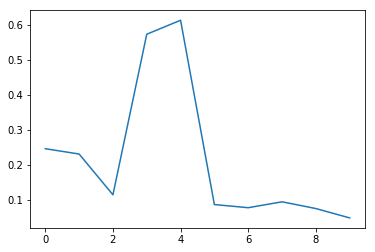

In [17]:
plt.plot(alpha)

In [18]:
alpha.sum()

2.153459151183312